# Import and Read Data

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import gpboost as gpb
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn import metrics, model_selection
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve, auc, 
                             ConfusionMatrixDisplay, mean_squared_error)
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, GroupKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
filepaths = {
    "original_data": "../Data/original_data.csv",
    "original_no_overdose_data": "../Data/original_no_overdose_data.csv",
    "original_overdose_data": "../Data/original_overdose_data.csv"
}

for key, path in filepaths.items():
    data = pd.read_csv(path, dtype=object)
    data['Residence_State'] = data['Residence_State(FIPS)']
    data.drop('Residence_State(FIPS)', axis=1, inplace=True)
    globals()[key] = data

# Split Data to train, and test


In [3]:
def data_split_and_label(data_set, label_value):
    """Splits the data into train and test sets and adds a label."""
    train, test = model_selection.train_test_split(data_set, test_size=0.3)
    train.insert(0, "y_value", label_value)
    test.insert(0, "y_value", label_value)
    return train, test

# Splitting data and adding labels
train_class_0, test_class_0 = data_split_and_label(original_no_overdose_data, 0)
train_class_1, test_class_1 = data_split_and_label(original_overdose_data, 1)

# Resampling the non-overdose data
num_of_samples = len(train_class_1)
train_class_0_resampled = [train_class_0.sample(num_of_samples) for _ in range(1)]
test_class_0_resampled = [test_class_0.sample(int(3*num_of_samples/7)) for _ in range(1)]

# Combining and shuffling
arrayoftrain = [(pd.concat([train_0, train_class_1])).sample(frac=1) for train_0 in train_class_0_resampled]
arrayoftest = [(pd.concat([test_0, test_class_1])).sample(frac=1) for test_0 in test_class_0_resampled]

# Group by Race and others

In [4]:
numofclass0 = 1
def process_data(array_of_data, columns_to_drop):
    x_data = []
    y_data = []
    
    for data in array_of_data:
        data_x = data.drop(columns=columns_to_drop).sample(n=len(data))
        data_y = data_x.pop("y_value").astype(bool)
        x_data.append(data_x)
        y_data.append(data_y)
        
    return x_data, y_data

# Define columns to drop
columns_to_drop = ["The_Decedent_Education", "Residence_Met_or_Nonmet_county", "Residence_County(FIPS)", 
                   "The_Decedent_Marital_status", "General_Place_of_death_and_decedents_status", 
                   "The_Decedent_State_or_country_of_birth", "Occurrence_County_Population_size", 
                   "Occurrence_County(FIPS)", "Occurrence_State(FIPS)", "General_Day_of_week_of_death", 
                   "General_Record_Type", "General_Resident_status", "General_Manner_of_death", 
                   "The_Decedent_Date_of_Death", "Underlying_Cause_ICD-10_code", "The_Decedent_Race_Recode_5", 
                   "The_Decedent_Hispanic_Origin/Race_Recode"]

# Process main data
arrayoftrain_x, arrayoftrain_y = process_data(arrayoftrain, columns_to_drop)
arrayoftest_x, arrayoftest_y = process_data(arrayoftest, columns_to_drop)

# Using dictionaries to process data by group
grouped_data_keys = ['white', 'black', 'AmericanIndian', 'asian', 'hispanic', 'male', 'female', 'Metropolitan', 'Nonmetropolitan', 'Foreignresidents']
grouped_data = {key: [] for key in grouped_data_keys}

grouped_columns = {
    'white': 'The_Decedent_Race',
    'black': 'The_Decedent_Race',
    'AmericanIndian': 'The_Decedent_Race',
    'asian': 'The_Decedent_Race',
    'hispanic': 'The_Decedent_Race',
    'male': 'The_Decedent_Sex',
    'female': 'The_Decedent_Sex',
    'Metropolitan': 'Residence_Met_or_Nonmet_county',
    'Nonmetropolitan': 'Residence_Met_or_Nonmet_county',
    'Foreignresidents': 'Residence_Met_or_Nonmet_county'
}

grouped_values = {
    'white': '1',
    'black': '2',
    'AmericanIndian': '3',
    'asian': '4',
    'hispanic': '6',
    'male': 'M',
    'female': 'F',
    'Metropolitan': '1',
    'Nonmetropolitan': '2',
    'Foreignresidents': 'Z'
}

for i in range(numofclass0):
    for key in grouped_data_keys:
        grouped = arrayoftest[i].groupby(grouped_columns[key])
        grouped_data[key].append(grouped.get_group(grouped_values[key]))

# Process grouped data
grouped_data_x, grouped_data_y = {}, {}
for key in grouped_data_keys:
    x, y = process_data(grouped_data[key], columns_to_drop)
    grouped_data_x[key] = x
    grouped_data_y[key] = y


# FixEffect

# FixEffect for XGBOOST

In [5]:
# Define X and y
X, y = arrayoftrain_x[0], arrayoftrain_y[0]

# Convert 'object' dtype columns to categorical type
categorical_columns = ['The_Decedent_Sex', 'The_Decedent_Race', 'Residence_State']

for col in categorical_columns:
    X[col] = X[col].astype('category')

# Convert columns which are numerical but represented as 'object' to their respective types
numerical_as_object = ['General_Data_year', 'The_Decedent_Age']
for col in numerical_as_object:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Define the model and parameters
params = {
    'learning_rate': [0.07],
    'max_depth': [7],
    'n_estimators': [150],
    'colsample_bytree': [0.7],
    'subsample': [0.9],
    'gamma': [0.4],
    'reg_alpha': [0.005],
    'reg_lambda': [0.3],
    'tree_method': ['gpu_hist'],
    'enable_categorical': [True]
}

model = xgb.XGBClassifier()

# Outer CV for model evaluation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)  # Using StratifiedKFold for balanced splits

for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Inner CV for hyperparameter tuning
    inner_cv = KFold(n_splits=5, shuffle=True)
    grid_search = GridSearchCV(model, param_grid=params, cv=inner_cv, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Output the best parameters for each fold
    print(f'Best parameters for fold {i + 1}: {best_params}')
    
    # Predicting on the test set
    y_pred = best_model.predict(X_test)
    
    # Getting metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    
    # Printing metrics for each fold
    print(f"Fold {i + 1}:")
    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability

Best parameters for fold 1: {'colsample_bytree': 0.7, 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Fold 1:
True Positives (TP): 68317
False Positives (FP): 14488
True Negatives (TN): 60831
False Negatives (FN): 7002
Accuracy: 0.8573
Precision: 0.8250
Recall: 0.9070
F1 Score: 0.8641
AUC-ROC: 0.9221
--------------------------------------------------
Best parameters for fold 2: {'colsample_bytree': 0.7, 'enable_categorical': True, 'gamma': 0.4, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Fold 2:
True Positives (TP): 68238
False Positives (FP): 14317
True Negatives (TN): 61002
False Negatives (FN): 7081
Accuracy: 0.8580
Precision: 0.8266
Recall: 0.9060
F1 Score: 0.8645
AUC-ROC: 0.9234
--------------------------------------------------
Best parameters fo

Processing class 0...
Accuracy: 85.35%


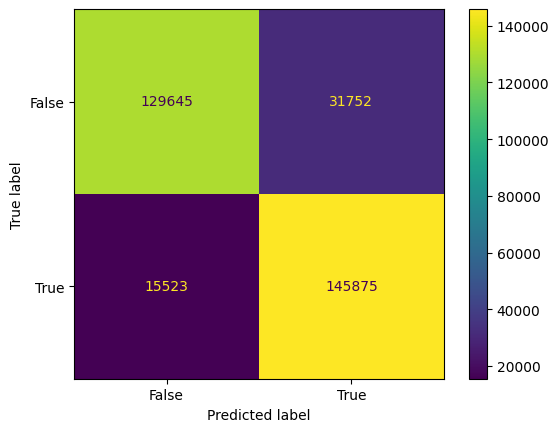

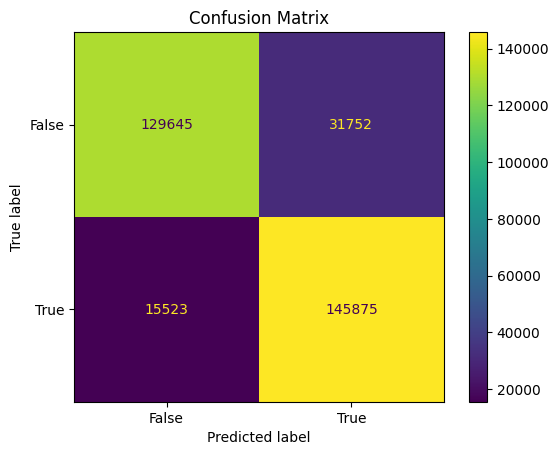

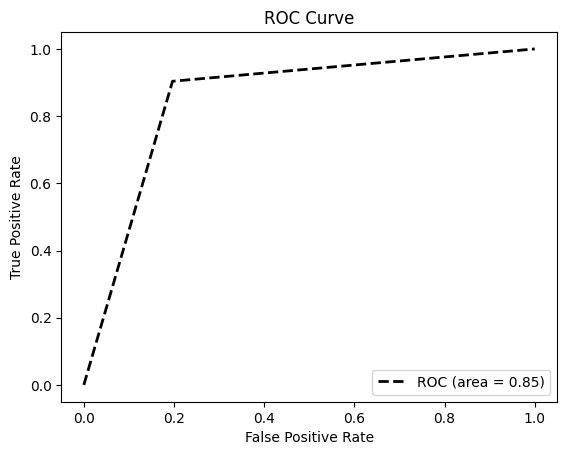

Precision Score: 0.86
Recall Score: 0.85


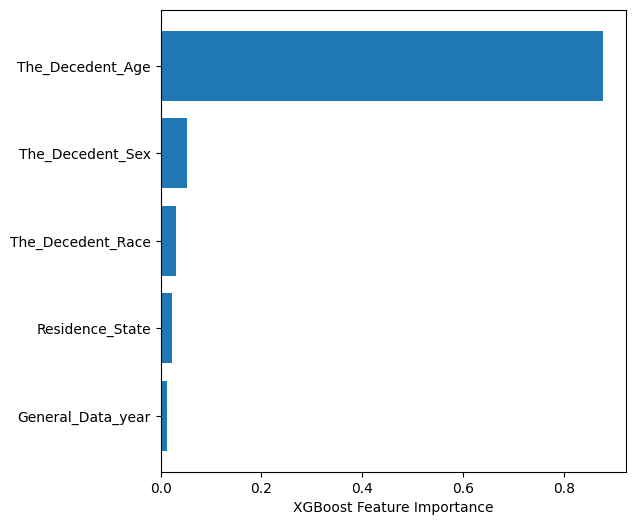

In [6]:
def train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y):
    """Train and evaluate an XGBoost model."""
    
    # Define hyperparameters
    params = {
        'learning_rate': 0.07,
        'max_depth': 7,
        'n_estimators': 150,
        'subsample': 0.9,
        'colsample_bytree': 0.6,
        'gamma': 0.4,
        'reg_alpha': 0.005,
        'reg_lambda': 0.3,
        'objective': 'binary:logistic',
        'seed': 40,
        'tree_method': 'gpu_hist',
        'enable_categorical': True
    }

    # Initialize and train the XGBoost model
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(train_x, train_y)

    # Predict on the test data
    y_pred = xgb_model.predict(test_x)

    # Display accuracy
    accuracy = metrics.accuracy_score(test_y, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(xgb_model, test_x, test_y).plot()
    plt.title('Confusion Matrix')
    plt.show()

    # Display ROC curve
    fpr, tpr, _ = roc_curve(test_y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'k--', label=f'ROC (area = {roc_auc:.2f})', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')
    plt.show()

    # Display precision and recall
    print(f"Precision Score: {precision_score(test_y, y_pred, average='macro'):.2f}")
    print(f"Recall Score: {recall_score(test_y, y_pred, average='macro'):.2f}")

    # Display feature importances
    plt.figure(figsize=(6, 6))
    sorted_idx = xgb_model.feature_importances_.argsort()
    plt.barh(train_x.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
    plt.xlabel("XGBoost Feature Importance")
    plt.show()
    
    # Return the trained model (optional)
    return xgb_model

def preprocess_dataframe(df):
    # Convert categorical columns to 'category' dtype
    categorical_cols = ['The_Decedent_Sex', 'The_Decedent_Race', 'Residence_State']
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    # Convert numerical columns stored as strings to 'int' or 'float'
    numeric_cols = ['General_Data_year', 'The_Decedent_Age']
    for col in numeric_cols:
        df[col] = df[col].astype(int)  # or float, if needed

    return df

# Apply preprocessing to all datasets
arrayoftrain_x = [preprocess_dataframe(df) for df in arrayoftrain_x]
arrayoftest_x = [preprocess_dataframe(df) for df in arrayoftest_x]


for idx in range(numofclass0):
    train_x, train_y = arrayoftrain_x[idx], arrayoftrain_y[idx]
    test_x, test_y = arrayoftest_x[idx], arrayoftest_y[idx]
    
    print(f"Processing class {idx}...")
    train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y)


# FixEffect for Linear

In [11]:
# Encode labels
train_x['Label'] = train_y
test_x['Label'] = test_y

combined = pd.concat([train_x, test_x], axis=0)

le_dict = {}

for col in combined.columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    le_dict[col] = le

# Split the datasets back, making sure to work with copies
train_x_encoded = combined.iloc[:len(train_x)].copy()
test_x_encoded = combined.iloc[len(train_x):].copy()

# Fix the dtype of 'Label' column
train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

# Define the formula for your fixed effects model
formula = 'Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age + The_Decedent_Race + Residence_State'

# Create a fixed effects model from your data
fixed_effect_model = smf.ols(formula, data=train_x_encoded)

# Fit the model
fixed_effect_model_fit = fixed_effect_model.fit()

# Print the summary
print(fixed_effect_model_fit.summary())

# Predict the outcomes on the test set
test_df = test_x_encoded.copy()
test_df['predicted_values'] = fixed_effect_model_fit.predict(test_df)

# Convert predicted values to binary 0 or 1 based on threshold
test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

# Calculate the metrics
accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
precision = precision_score(test_df['Label'], test_df['predicted_binary'])
recall = recall_score(test_df['Label'], test_df['predicted_binary'])
f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values']) # Use predicted_values for AUC
tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()

print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

                            OLS Regression Results                            
Dep. Variable:                  Label   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                 1.932e+05
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:03:39   Log-Likelihood:            -2.8080e+05
No. Observations:              753190   AIC:                         5.616e+05
Df Residuals:                  753185   BIC:                         5.617e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2427      0.00

# MixEffect

## MixEffect for XGBoost

In [12]:
# 1. Prepare the data

# 2. Define the parameter grid for tuning
param_grid = {
    'max_depth': [7],
    'n_estimators': [150],
    'colsample_bytree': [0.7],
    'subsample': [0.9],
    #'gamma': [0.4],
    'reg_alpha': [0.005],
    'reg_lambda': [0.3],
    #'tree_method': ['gpu_hist'],
    #'enable_categorical': [True]
}

# 3. Nested CV for hyperparameter tuning and model evaluation
outer_cv = GroupKFold(n_splits=5)
inner_cv = GroupKFold(n_splits=5)

for i, (train_idx, test_idx) in enumerate(outer_cv.split(train_x_encoded, groups=train_x_encoded['Residence_State'])):
    
    # Splitting the data
    X_train, X_test = train_x_encoded.iloc[train_idx], train_x_encoded.iloc[test_idx]
    
    # Re-computing the group data for the current fold
    group_data_train = X_train.groupby('Residence_State').size().values
    group_data_test = X_test.groupby('Residence_State').size().values
    
    train_data = gpb.Dataset(data=X_train.drop(columns=['Residence_State', 'Label']), label=X_train['Label'], group=group_data_train)
    test_data = gpb.Dataset(data=X_test.drop(columns=['Residence_State', 'Label']), label=X_test['Label'], group=group_data_test)
    
    # Inner CV for hyperparameter tuning
    model = gpb.GPBoostClassifier()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train.drop(columns=['Residence_State', 'Label']), X_train['Label'], groups=X_train['Residence_State'])

    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Output the best parameters for each fold
    print(f'Best parameters for fold {i + 1}: {best_params}')
    
    # Make predictions and evaluate the performance of the model
    preds_prob = best_model.predict_proba(X_test.drop(columns=['Residence_State', 'Label']))[:, 1]
    
    # Convert predictions to binary outcomes
    threshold = 0.5
    preds_binary = (preds_prob > threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(X_test['Label'], preds_binary)
    precision = precision_score(X_test['Label'], preds_binary)
    recall = recall_score(X_test['Label'], preds_binary)
    f1 = f1_score(X_test['Label'], preds_binary)
    roc_auc = roc_auc_score(X_test['Label'], preds_prob)
    tn, fp, fn, tp = confusion_matrix(X_test['Label'], preds_binary).ravel()
    
    # Printing metrics for each fold
    print(f"Fold {i + 1}:")
    print(f'True Positives (TP): {tp}')
    print(f'False Positives (FP): {fp}')
    print(f'True Negatives (TN): {tn}')
    print(f'False Negatives (FN): {fn}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print('-' * 50)  # printing a separator for better readability

Best parameters for fold 1: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 1:
True Positives (TP): 62595
False Positives (FP): 14565
True Negatives (TN): 64255
False Negatives (FN): 8755
Accuracy: 0.8447
Precision: 0.8112
Recall: 0.8773
F1 Score: 0.8430
AUC-ROC: 0.9135
--------------------------------------------------
Best parameters for fold 2: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 2:
True Positives (TP): 69813
False Positives (FP): 14674
True Negatives (TN): 59107
False Negatives (FN): 6726
Accuracy: 0.8576
Precision: 0.8263
Recall: 0.9121
F1 Score: 0.8671
AUC-ROC: 0.9213
--------------------------------------------------
Best parameters for fold 3: {'colsample_bytree': 0.7, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0.005, 'reg_lambda': 0.3, 'subsample': 0.9}
Fold 3:
True Positives (TP): 67273
False Positives (FP

## MixEffect for Linear 

In [13]:
# Encode labels
train_x['Label'] = train_y
test_x['Label'] = test_y

combined = pd.concat([train_x, test_x], axis=0)

le_dict = {}

for col in combined.columns:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    le_dict[col] = le

# Split the datasets back, making sure to work with copies
train_x_encoded = combined.iloc[:len(train_x)].copy()
test_x_encoded = combined.iloc[len(train_x):].copy()

# Fix the dtype of 'Label' column
train_x_encoded['Label'] = train_x_encoded['Label'].astype(int)

# Define the formula for your mixed effects model
formula = 'Label ~ General_Data_year + The_Decedent_Sex + The_Decedent_Age + The_Decedent_Race + (1 | Residence_State)'

# Create a mixed effects model from your data
mixed_effect_model = smf.mixedlm(formula, data=train_x_encoded, groups=train_x_encoded['Residence_State'])

# Fit the model
mixed_effect_model_fit = mixed_effect_model.fit()

# Print the summary
print(mixed_effect_model_fit.summary())

# Predict the outcomes on the test set
test_df = test_x_encoded.copy()
test_df['predicted_values'] = mixed_effect_model_fit.predict(test_df)

# Convert predicted values to binary 0 or 1 based on threshold
test_df['predicted_binary'] = test_df['predicted_values'].apply(lambda x: 1 if x > 0.5 else 0)

# Calculate the metrics
accuracy = accuracy_score(test_df['Label'], test_df['predicted_binary'])
precision = precision_score(test_df['Label'], test_df['predicted_binary'])
recall = recall_score(test_df['Label'], test_df['predicted_binary'])
f1 = f1_score(test_df['Label'], test_df['predicted_binary'])
roc_auc = roc_auc_score(test_df['Label'], test_df['predicted_values']) # Use predicted_values for AUC
tn, fp, fn, tp = confusion_matrix(test_df['Label'], test_df['predicted_binary']).ravel()

print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\zixuc\anaconda3\envs\xgboost-gpu\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Label       
No. Observations:   753190    Method:               REML        
No. Groups:         56        Scale:                0.1223      
Min. group size:    1         Log-Likelihood:       -277433.0114
Max. group size:    68669     Converged:            Yes         
Mean group size:    13449.8                                     
----------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            1.237    0.014   89.188 0.000  1.210  1.264
General_Data_year    0.008    0.000   54.204 0.000  0.007  0.008
The_Decedent_Sex    -0.013    0.001  -15.195 0.000 -0.014 -0.011
The_Decedent_Age    -0.016    0.000 -852.659 0.000 -0.016 -0.016
The_Decedent_Race   -0.021    0.000  -54.330 0.000 -0.021 -0.020
1 | Residence_State  0.000    0.000    

# AI 360

In [14]:
import aif360.datasets as datasets
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Ensure that all object type columns are encoded to numerical
le = LabelEncoder()
for column in train_x_encoded.select_dtypes(include=['object']).columns:
    train_x_encoded[column] = le.fit_transform(train_x_encoded[column])

# Convert dataframes to a BinaryLabelDataset format which is required by aif360
dataset_train = datasets.BinaryLabelDataset(favorable_label=1,
                                            unfavorable_label=0,
                                            df=train_x_encoded,
                                            label_names=['Label'],
                                            protected_attribute_names=['The_Decedent_Race'])

print(train_x_encoded["The_Decedent_Race"].value_counts())

privileged_groups = [{'The_Decedent_Race': 0}]
unprivileged_groups = [{'The_Decedent_Race': 1},
                       {'The_Decedent_Race': 2},
                       {'The_Decedent_Race': 3},
                       {'The_Decedent_Race': 4}]

# Compute fairness metric on original training dataset
metric_train = BinaryLabelDatasetMetric(dataset_train, 
                                        unprivileged_groups=unprivileged_groups, 
                                        privileged_groups=privileged_groups)
print("Mean difference (statistical parity difference) = %f" % metric_train.mean_difference())

# Bias mitigation
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_train)

# Check the fairness metric for the transformed dataset
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups, 
                                               privileged_groups=privileged_groups)
print("Transformed training dataset mean difference = %f" % metric_transf_train.mean_difference())


`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

The_Decedent_Race
0    592284
1     85484
4     55981
3     12968
2      6473
Name: count, dtype: int64
Mean difference (statistical parity difference) = 0.007058
Transformed training dataset mean difference = -0.000000


In [ ]:
# Convert the 'Residence_State' column to category type
train_x['Residence_State'] = train_x['Residence_State'].astype('category')
test_x['Residence_State'] = test_x['Residence_State'].astype('category')

# Convert the category labels to codes
train_x['Residence_State'] = train_x['Residence_State'].cat.codes
test_x['Residence_State'] = test_x['Residence_State'].cat.codes

for i in range(numofclass0):
    print(f"Processing iteration {i}...")
    train_and_evaluate_xgb_model(train_x, train_y, test_x, test_y)



# Fairlearn

# Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression( penalty='l2', tol=0.001, C=2000,random_state=0, max_iter=500, solver='newton-cg').fit(train_x_encoded.drop('Label', axis=1), train_x_encoded['Label'])
y_pred=lr_clf.predict(test_x_encoded.drop('Label', axis=1))
#y_pred
#lr_clf.predict_proba(train_x_norm)
print(lr_clf.score(test_x_encoded.drop('Label', axis=1), test_x_encoded['Label']))
#print(lr_clf.score(train_x_encoded.drop('Label', axis=1), train_x_encoded['Label']))

fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(test_x_encoded['Label'], y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

NameError: name 'train_x_encoded' is not defined

In [44]:
color = 'black'
matrix = plot_confusion_matrix(lr_clf, test_x_encoded.drop('Label', axis=1), test_x_encoded['Label'], cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

NameError: name 'plot_confusion_matrix' is not defined

In [45]:
print(precision_score(test_x_encoded.drop('Label', axis=1), y_pred, average='macro'))

print(recall_score(test_x_encoded.drop('Label', axis=1), y_pred, average='macro'))





ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets

# SVM

In [ ]:
from sklearn import svm

def support_vector_machine(train_x_hashed, train_y, validation_x, validation_y):
  clf = svm.SVC(C = 455000000, max_iter =  10000)
  clf.fit(train_x_hashed, train_y)
  y_pred = clf.predict(validation_x)
  accuracy = metrics.accuracy_score(validation_y, y_pred)
  return accuracy, y_pred, clf

In [ ]:
validation_accuracy, y_pred, svm_model = support_vector_machine(train_x_hashed, train_y, validation_x_hashed, validation_y)
print(validation_accuracy)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

# KNN

In [ ]:
def KNN_test(train_x, train_y, validation_x, validation_y, k, m, n):
  KNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=m, leaf_size=n)
  KNN.fit(train_x, train_y)
  y_pred = KNN.predict(validation_x)
  acc = metrics.accuracy_score(validation_y, y_pred)
  model = KNN
  return acc, y_pred, model

In [ ]:
acc, y_pred, knn_model = KNN_test(train_x_hashed, train_y, validation_x_hashed, validation_y, k=5, m=15, n=40)
print('test accuracy:', acc)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
KNN = sklearn.neighbors.KNeighborsClassifier()

params = {'n_neighbors': [5, 6, 7, 8, 10, 15, 20], 'leaf_size': [20, 30, 40, 50], 'n_jobs' : [10, 15, 16, 18, 20]}

rs_model=RandomizedSearchCV(KNN,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

#model fitting
rs_model.fit(train_x_hashed, train_y)

#parameters selected
print(rs_model.best_estimator_)

print (rs_model.best_score_)


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

color = 'black'
matrix = plot_confusion_matrix(knn_model, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('KNN Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(train_x, train_y, validation_x, validation_y, n_est=100):
  clf = RandomForestClassifier(n_estimators = n_est, min_samples_split=2, min_samples_leaf=4, max_depth=90, bootstrap=True)
  clf.fit(train_x, train_y)
  y_pred = clf.predict(validation_x)
  accuracy = metrics.accuracy_score(validation_y, y_pred)
  model = clf
  return accuracy, y_pred, model

In [ ]:
validation_accuracy, y_pred,random_forest_model = random_forest(train_x_hashed, train_y, validation_x_hashed, validation_y, 30)
print(validation_accuracy)
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

color = 'black'
matrix = plot_confusion_matrix(random_forest_model, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Create a search grid of parameters that will be shuffled through

n_estimators = [5, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 30, 35, 40] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9,10] # minimum sample number to split a node
min_samples_leaf = [1, 2, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(train_x_hashed, train_y)

print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(train_x.shape[1])]
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(random_forest_model.estimators_[0], out_file='tree.dot',
                feature_names = train_x.columns, filled=True,
                rounded=True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in python
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show();

# Neural Network1

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential([
    Dense(units=12, input_dim=19,activation='relu'),
    Dense(units=9, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()

In [ ]:
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_x_hashed, y=train_y, epochs=100)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=80)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.figure(figsize=(20, 8), dpi=80)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
y_pred = (model.predict(validation_x_hashed) > 0.5).astype("int32")

fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay

color = 'black'
matrix = metrics.confusion_matrix(y_true=validation_y, y_pred=y_pred)  # shape=(12, 12)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['True', 'False'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', color=color)
plt.show()

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(validation_y, y_pred, average='macro'))

print(recall_score(validation_y, y_pred, average='macro'))

In [ ]:
acc = model.evaluate(x=validation_x_hashed, y=validation_y)

# Correaltion Map

In [ ]:
original_data

In [ ]:
original_data.corr()

In [ ]:

correlation_matrix = original_data.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()


# Norm xgb


In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=2, random_state=30)

xgb_model.fit(norm_train_x, train_y)

# make predictions for test data
y_pred = xgb_model.predict(norm_validation_x)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(validation_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

color = 'black'
matrix = plot_confusion_matrix(xgb_model, norm_validation_x, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()


In [ ]:
print(precision_score(validation_y, y_pred, average='macro'))
print(recall_score(validation_y, y_pred, average='macro'))



figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(norm_train_x.shape[1])]
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



xgb.to_graphviz(xgb_model)

In [ ]:
print(category_features[5])
print(category_features[15])
print(category_features[2])
print(category_features[18])
print(category_features[12])
print(category_features[13])
print(category_features[3])

In [ ]:
dtrain = xgb.DMatrix(train_x_hashed, label=train_y)
params = {'objective': 'binary:logistic', 'eval_metric': 'error'}

# Perform 5-fold cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics='error', early_stopping_rounds=10)

# Print the results
print(cv_results)

In [ ]:
# Plot the training and test error
plt.plot(cv_results['train-error-mean'], label='Training Error')
plt.plot(cv_results['test-error-mean'], label='Test Error')

# Add a legend and labels
plt.legend()
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Cross-Validation Results')

# Show the plot
plt.show()